In [1]:
# data manipulation
import pandas as pd
import numpy as np

# visualization
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision Tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
loan = pd.read_csv('Xtrain.csv')
loan_outcome = pd.read_csv('Ytrain.csv')

loan = pd.merge(loan, loan_outcome, left_on='Id', right_on='Id1', how='left').drop('Id1', axis=1)

loan.dtypes

Id                     int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
GrAppv                object
SBA_Appv              object
ChargeOff              int64
dtype: object

In [3]:
print(loan.isna().sum())

loan_clean = loan.dropna()
print(loan_clean.isna().sum())

Id                     0
Name                   1
City                   0
State                  0
Zip                    0
Bank                  76
BankState             77
NAICS                  0
ApprovalDate           0
ApprovalFY             0
Term                   0
NoEmp                  0
NewExist               7
CreateJob              0
RetainedJob            0
FranchiseCode          0
UrbanRural             0
RevLineCr            153
LowDoc               172
DisbursementDate     119
DisbursementGross      0
BalanceGross           0
GrAppv                 0
SBA_Appv               0
ChargeOff              0
dtype: int64
Id                   0
Name                 0
City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
ApprovalDate         0
ApprovalFY           0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode    

In [4]:
loan_clean['DisbursementGross'] = loan_clean['DisbursementGross'].str.replace('$', '').str.replace(',', '').astype(float)
loan_clean['GrAppv'] = loan_clean['GrAppv'].str.replace('$', '').str.replace(',', '').astype(float)
loan_clean['SBA_Appv'] = loan_clean['SBA_Appv'].str.replace('$', '').str.replace(',', '').astype(float)

# Remove records where RevLineCr != 'Y' or 'N' and LowDoc != 'Y' or 'N'
loan_clean = loan_clean[(loan_clean['RevLineCr'] == 'Y') | (loan_clean['RevLineCr'] == 'N')]
loan_clean = loan_clean[(loan_clean['LowDoc'] == 'Y') | (loan_clean['LowDoc'] == 'N')]

# RevLineCr and LowDoc: 0 = No, 1 = Yes
loan_clean['RevLineCr'] = np.where(loan_clean['RevLineCr'] == 'N', 0, 1)
loan_clean['LowDoc'] = np.where(loan_clean['LowDoc'] == 'N', 0, 1)

# Check that it worked
print(loan_clean['RevLineCr'].unique())
print(loan_clean['LowDoc'].unique())

[0 1]
[0 1]


In [5]:
# Create a new column with the industry the NAICS code represents
# Selects only the first two numbers of the NAICS code
loan_clean['Industry'] = loan_clean['NAICS'].astype('str').apply(lambda x: x[:2])

# Maps the approprate industry to each record based on the first two digits of the NAICS code
loan_clean['Industry'] = loan_clean['Industry'].map({
    '11': 'Ag/For/Fish/Hunt',
    '21': 'Min/Quar/Oil_Gas_ext',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale_trade',
    '44': 'Retail_trade',
    '45': 'Retail_trade',
    '48': 'Trans/Ware',
    '49': 'Trans/Ware',
    '51': 'Information',
    '52': 'Finance/Insurance',
    '53': 'RE/Rental/Lease',
    '54': 'Prof/Science/Tech',
    '55': 'Mgmt_comp',
    '56': 'Admin_sup/Waste_Mgmt_Rem',
    '61': 'Educational',
    '62': 'Healthcare/Social_assist',
    '71': 'Arts/Entertain/Rec',
    '72': 'Accom/Food_serv',
    '81': 'Other_no_pub',
    '92': 'Public_Admin'
})

# Remove records where Industry is NaN (NAICS code was a 0)
loan_clean.dropna(subset=['Industry'], inplace=True)
#loan_clean.head()

In [6]:
loan_clean[['ApprovalDate', 'DisbursementDate']] = loan_clean[['ApprovalDate', 'DisbursementDate']].apply(pd.to_datetime)

# number of days passed between DisbursementDate and ApprovalDate
loan_clean['DaysToDisbursement'] = loan_clean['DisbursementDate'] - loan_clean['ApprovalDate']

# Change DaysToDisbursement from a timedelta64 dtype to an int64 dtype
# Converts series to str, removes all characters after the space before 'd' in days for each record, then changes the dtype to int
loan_clean['DaysToDisbursement'] = loan_clean['DaysToDisbursement'].astype('str').apply(lambda x: x[:x.index('d') - 1]).astype('int64')
loan_clean.head()


,Id,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,ChargeOff,Industry,DaysToDisbursement
0,0,"NPE Realty, LLC",Pembroke Pines,FL,33027,"TD BANK, NATIONAL ASSOCIATION",DE,334516,2010-04-16,2010,...,0,0,2010-05-01,2000000.0,$0.00,2000000.0,1500000.0,0,Manufacturing,15
1,1,"KEVCO CONSTRUCTION, LLC",SANDY,UT,84094,ZIONS FIRST NATIONAL BANK,UT,236115,2010-01-30,2010,...,0,0,2010-02-01,17000.0,$0.00,17000.0,17000.0,1,Construction,2
2,2,EAST L A SHOE REPAIR,LOS ANGELES,CA,90022,BANK OF AMERICA NATL ASSOC,NC,811430,2002-07-29,2002,...,1,0,2002-08-31,17000.0,$0.00,17000.0,8500.0,0,Other_no_pub,33
7,7,SA SA LLC,ELLICOTT CITY,MD,21043,HOWARD BANK,MD,423940,2010-01-15,2010,...,0,0,2010-02-01,75000.0,$0.00,75000.0,67500.0,1,Wholesale_trade,17
9,9,Hoke Trucking Ltd.,Acranum,OH,45304,CALIFORNIA BANK & TRUST,CA,484121,2007-01-19,2007,...,0,0,2007-01-31,100000.0,$0.00,100000.0,50000.0,1,Trans/Ware,12


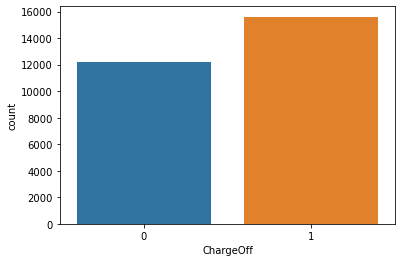

In [7]:

plot = sb.countplot(loan_clean.ChargeOff)

In [8]:
loan_clean['ApprovalFY'] = loan_clean['ApprovalFY'].astype('int64')

numeric = ['ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
           'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross', 
            'GrAppv', 'SBA_Appv']
num_df = loan_clean[numeric]
num_df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
ApprovalFY,27837.0,2004.171319,4.955652,1987.0,2003.0,2006.0,2007.0,2014.0
Term,27837.0,74.150268,60.733479,0.0,37.0,60.0,84.0,360.0
NoEmp,27837.0,7.970830,28.616829,0.0,2.0,3.0,8.0,3000.0
NewExist,27837.0,1.261702,0.441526,0.0,1.0,1.0,2.0,2.0
CreateJob,27837.0,1.750943,12.460076,0.0,0.0,0.0,1.0,1150.0
RetainedJob,27837.0,4.608830,11.140218,0.0,0.0,2.0,5.0,404.0
UrbanRural,27837.0,0.984697,0.539684,0.0,1.0,1.0,1.0,2.0
RevLineCr,27837.0,0.463628,0.498684,0.0,0.0,0.0,1.0,1.0
LowDoc,27837.0,0.035420,0.184843,0.0,0.0,0.0,0.0,1.0
DisbursementGross,27837.0,143045.634120,236552.756454,1.0,30000.0,63057.0,150000.0,5000000.0


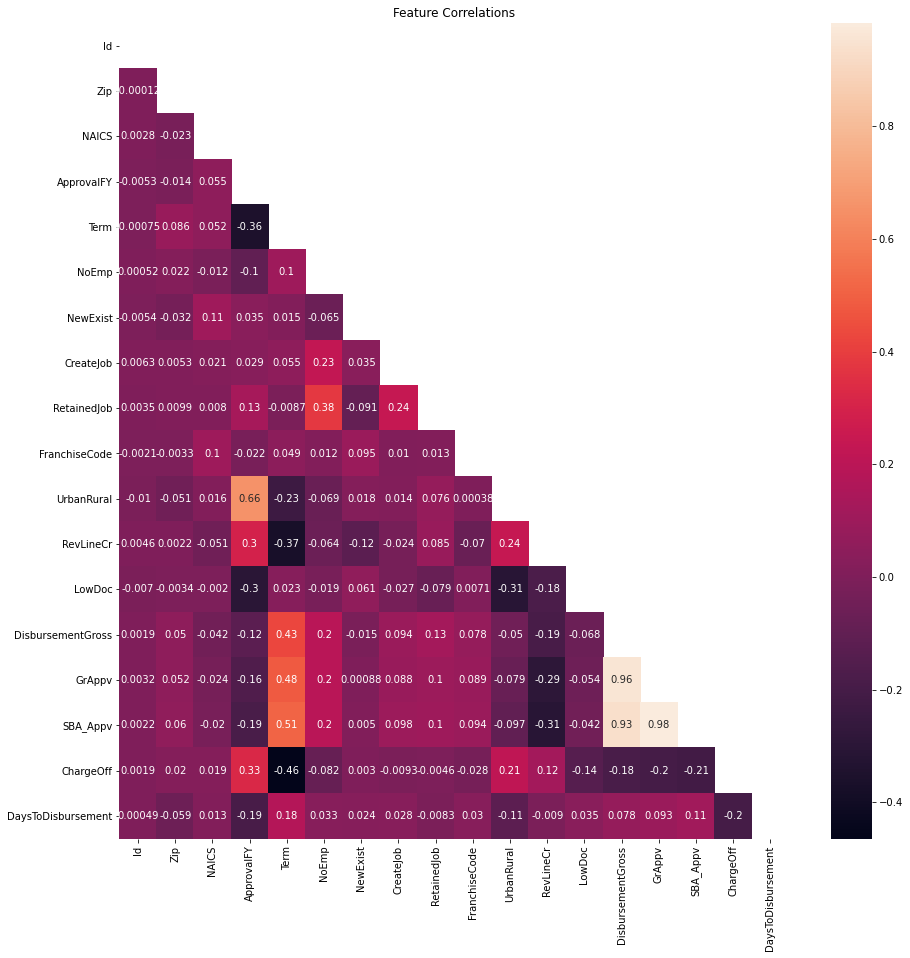

In [9]:
corr = loan_clean.corr()
fig, ax = plt.subplots(figsize=(15,15))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sb.heatmap(corr, annot = True, ax=ax, mask=mask).set(title='Feature Correlations')
plt.show()

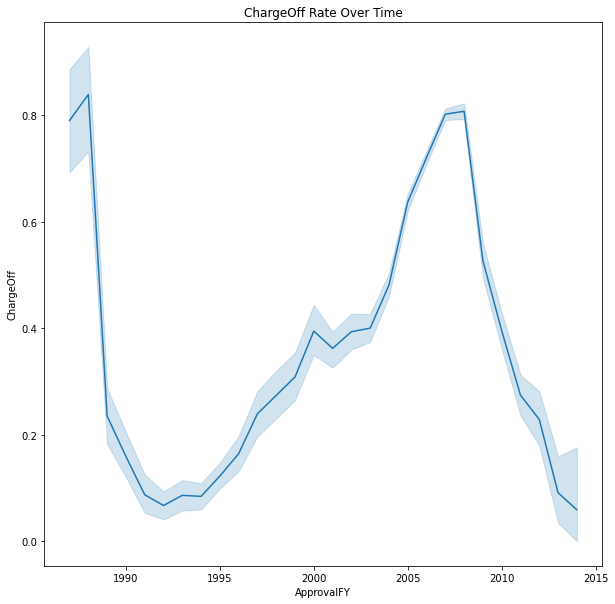

In [10]:
#plot
fig = plt.figure(figsize=(10,10))
#plot_order = loan_clean.sort_values(by='ApprovalFY', ascending=False).ChargeOff.values
sb.lineplot(x="ApprovalFY", y="ChargeOff", data=loan_clean)
plt.title('ChargeOff Rate Over Time')
plt.show()

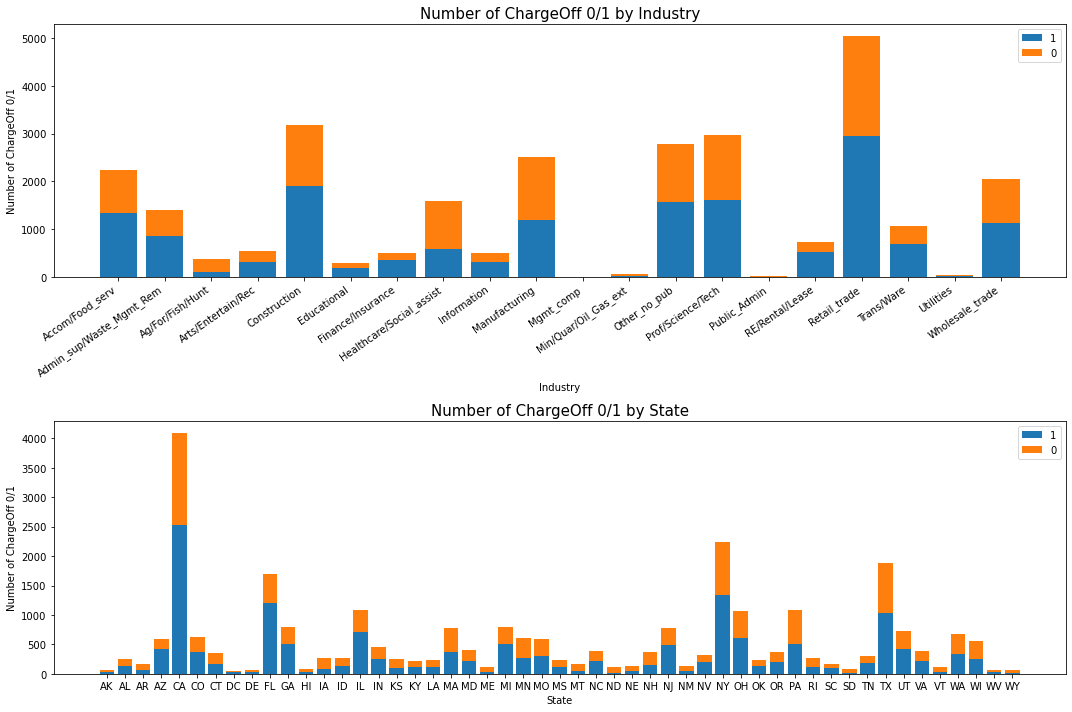

In [13]:
# Paid in full and defaulted loans
fig3 = plt.figure(figsize=(15, 10))

ax1a = plt.subplot(2, 1, 1)
ax2a = plt.subplot(2, 1, 2)

# Function for creating stacked bar charts grouped by desired column
# df = original data frame, col = x-axis grouping, stack_col = column to show stacked values
# Essentially acts as a stacked histogram when stack_col is a flag variable
def stacked_setup(df, col, axes, stack_col='ChargeOff'):
    data = df.groupby([col, stack_col])[col].count().unstack(stack_col)
    data.fillna(0)

    axes.bar(data.index, data[1], label='1')
    axes.bar(data.index, data[0], bottom=data[1], label='0')


# Number of Paid in full and defaulted loans by industry
stacked_setup(df=loan_clean, col='Industry', axes=ax1a)
ax1a.set_xticklabels(loan_clean.groupby(['Industry', 'ChargeOff'])['Industry'].count().unstack('ChargeOff').index,
                     rotation=35, horizontalalignment='right', fontsize=10)

ax1a.set_title('Number of ChargeOff 0/1 by Industry', fontsize=15)
ax1a.set_xlabel('Industry')
ax1a.set_ylabel('Number of ChargeOff 0/1')
ax1a.legend()

# Number of Paid in full and defaulted loans by State
stacked_setup(df=loan_clean, col='State', axes=ax2a)

ax2a.set_title('Number of ChargeOff 0/1 by State', fontsize=15)
ax2a.set_xlabel('State')
ax2a.set_ylabel('Number of ChargeOff 0/1')
ax2a.legend()

plt.tight_layout()
plt.show()